# Antiderivative operator from an unaligned dataset

# Problem setup

We will learn the antiderivative operator
$$
G: v \mapsto u
$$
defined by an ODE
$$
\frac{du(x)}{dx} = v(x), \qquad x \in [0, 1],
$$
with IC `u(0)=0`.

We learn `G` from a dataset. Each data point in the dataset is one triple of `(v, x, u(x))`, generated as follows:

1. A random function `v` is sampled from a Gaussian random field (GRF) with the resolution `m=100`.
2. Sovle `u` for `v` numerically. We assume that for each `u`, we have the values of `u(x)` in the only one random location $x$. Because for different $u$, we have the value of $u(x)$ in different random locations, we call this dataset as "unaligned data".

To use DeepONet, we need to organize the dataset in the following format:

- Input of the branch net: the functions $v$.
- Input of the trunck net: the locations $x$ of $u(x)$ values.
- Output: the values of $u(x)$ in different locations for different $v$.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
d = np.load("deepxde/deeponet_antiderivative_unaligned/antiderivative_unaligned_train.npz", allow_pickle=True)
d

NpzFile 'deepxde/deeponet_antiderivative_unaligned/antiderivative_unaligned_train.npz' with keys: X_train0, X_train1, y_train

In [ ]:
d['X_train0'].shape, d['X_train1'].shape, d['y_train'].shape

((10000, 100), (10000, 1), (10000, 1))

In [ ]:
X_train = (d['X_train0'].astype(np.float32), d['X_train1'].astype(np.float32))
y_train = d['y_train'].astype(np.float32)

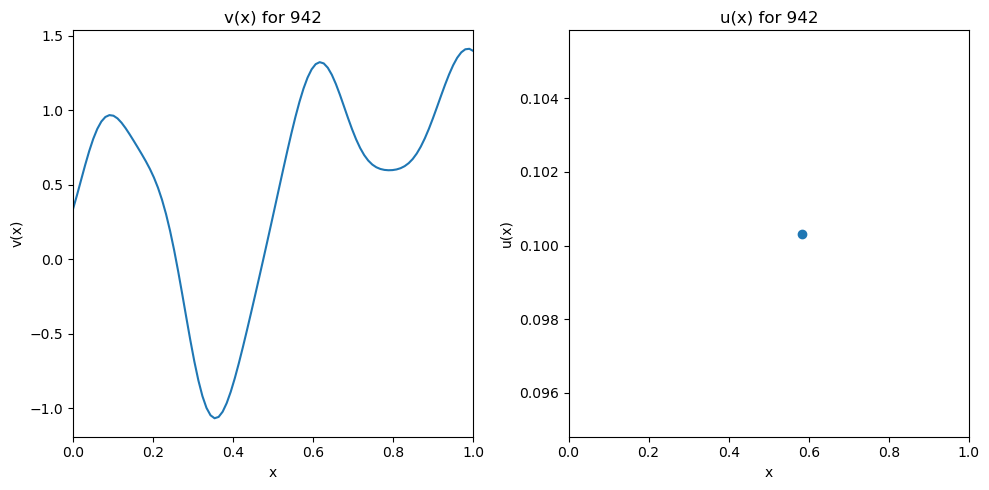

In [ ]:
idx = np.random.choice(10000)
xt = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(xt, X_train[0][idx, :])
plt.xlim([0, 1])
plt.xlabel('x')
plt.ylabel('v(x)')
plt.title(f'v(x) for {idx}')

plt.subplot(1, 2, 2)
plt.scatter(X_train[1][idx], y_train[idx, :])
plt.xlim([0, 1])
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'u(x) for {idx}')

plt.tight_layout()
plt.show()

In [ ]:
d = np.load("deepxde/deeponet_antiderivative_unaligned/antiderivative_unaligned_test.npz", allow_pickle=True)
d

NpzFile 'deepxde/deeponet_antiderivative_unaligned/antiderivative_unaligned_test.npz' with keys: X_test0, X_test1, y_test

In [ ]:
d['X_test0'].shape, d['X_test1'].shape, d['y_test'].shape

((100000, 100), (100000, 1), (100000, 1))

In [ ]:
X_test = (d['X_test0'].astype(np.float32), d['X_test1'].astype(np.float32))
y_test = d['y_test'].astype(np.float32)

In [ ]:
dde.data.Triple?

Init signature: dde.data.Triple(X_train, y_train, X_test, y_test)
Docstring:     
Dataset with each data point as a triple.

The couple of the first two elements are the input, and the third element is the
output. This dataset can be used with the network ``DeepONet`` for operator
learning.

Args:
    X_train: A tuple of two NumPy arrays.
    y_train: A NumPy array.

References:
    `L. Lu, P. Jin, G. Pang, Z. Zhang, & G. E. Karniadakis. Learning nonlinear
    operators via DeepONet based on the universal approximation theorem of
    operators. Nature Machine Intelligence, 3, 218--229, 2021
    <https://doi.org/10.1038/s42256-021-00302-5>`_.
File:           ~/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/deepxde/data/triple.py
Type:           ABCMeta
Subclasses:     

In [ ]:
data = dde.data.Triple(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
m = 100
dim_x = 1
net = dde.nn.DeepONet(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal"
)

In [ ]:
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.294681 s



In [ ]:
loss_history, train_state = model.train(iterations=10000)

Training model...

Step      Train loss    Test loss     Test metric
0         [2.01e-01]    [2.04e-01]    []  
1000      [6.80e-04]    [7.58e-04]    []  
2000      [3.83e-04]    [4.32e-04]    []  
3000      [2.91e-04]    [3.28e-04]    []  
4000      [2.08e-04]    [2.34e-04]    []  
5000      [1.54e-04]    [1.77e-04]    []  
6000      [1.23e-04]    [1.42e-04]    []  
7000      [9.30e-05]    [1.09e-04]    []  
8000      [8.38e-05]    [9.90e-05]    []  
9000      [7.30e-05]    [8.66e-05]    []  
10000     [6.18e-05]    [7.27e-05]    []  

Best model at step 10000:
  train loss: 6.18e-05
  test loss: 7.27e-05
  test metric: []

'train' took 43.406507 s



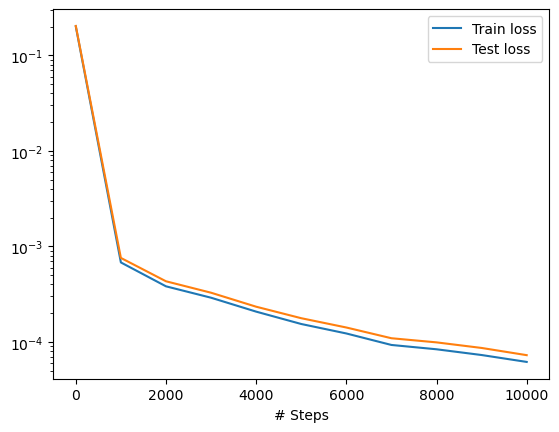

In [ ]:
dde.utils.plot_loss_history(loss_history)

## Evaluation

If $v(x) = \cos(\pi x)$, 

then $u(x) = \frac{1}{\pi} \sin(\pi x)$ with IC $u(x=0)=0$

In [ ]:
xt = np.linspace(0, 1, 100)
vt = np.cos(np.pi*xt)
ut = (1/np.pi)*np.sin(np.pi*xt)

In [ ]:
# v(x)                          x                            u(x)
X_train[0].shape, X_train[1].shape, y_train.shape

((10000, 100), (10000, 1), (10000, 1))

In [ ]:
vt.shape, xt.shape, ut.shape

((100,), (100,), (100,))

In [ ]:
vt = vt[None, :]
xt = xt[:, None]
ut = ut[None, :]

In [ ]:
vt.shape, xt.shape, ut.shape

((1, 100), (100, 1), (1, 100))

In [ ]:
Xt = (vt, xt)

In [ ]:
ut_pred = model.predict(Xt)
ut_pred.shape

(100, 1)

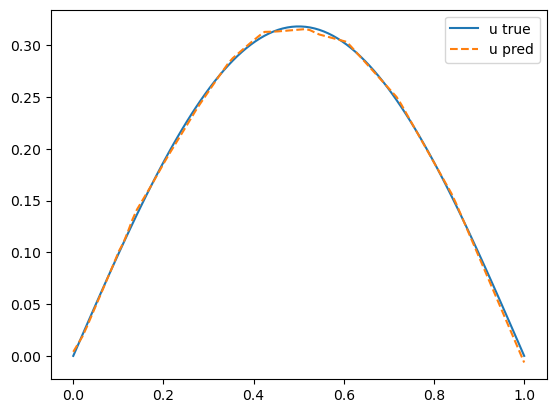

In [ ]:
plt.figure()
plt.plot(Xt[1][:, 0], ut[0, :], '-', label='u true')
plt.plot(Xt[1][:, 0], ut_pred[:, 0], '--', label='u pred')
plt.legend()
plt.show()